
# Shared rides with pricing - Delft 

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  
   ### TBD- Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
 



-------------------------------------------------------------------------------------------------------

# Pricing and Driver Earnings for a Two-Sided Mobility Platform: A Case of Amsterdam, the Netherlands

or 

# The Effects of Profit-Based Pricing on Driver Earnings and Performance of Two-Sided Mobility Platforms

# Abstract  

In this paper, we investigate how the  pricing of ride-pooling affects driver earnings. We also examine how profit-based setting affects these performance indicators. To this end, we applied a matching algorithm  to the case of ride-pooling and give a choice set to the driver for the case of Amsterdam, the Netherlands. For our simulation, we utilize an agent-based simulator reproducing the transport systems for two-sided mobility platforms (like Uber and Lyft) and applied three state-of-the-art pricing strategies such as <strong>profit maximization</strong>,  <strong>solo ride-hailing</strong>, and <strong>nearest pickup ride-pooling</strong>. We find that the profit maximization pricing strategy outperforms the other and traveler utility can be further improved by $\%X$ while reducing the total cost to serve the pooled rides. While offering a discount for profit maximization travel time is significantly higher $\%X$  than for private rides. 

-------------------------------------------------------------------------------------------------------

## Mode of Simulation 

Three type of simulation 

<strong>1. Profit maximization</strong> 

<strong>2. Solo ride-hailing</strong>

<strong>3. Nearest pickup ride-pooling</strong>

## Load ExMAS and MaaSSim


In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging
import matplotlib.pyplot as plt

import pandas as pd
import ExMAS

## Delft, Netherlands

In [2]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 4 # 6 minutes hour of simulation
params.nP = 200 # reuqests (and passengers)
params.nV = 20 # vehicles


## Parameters for ExMAS

In [3]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.25
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_veh' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True



# Strategy 1: 
# params.kpi = 1 (Profit Maximazation)


### Profit Mazimization - Begin 

In [4]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

23-02-23 13:37:06-INFO-Initializing pairwise trip shareability between 200 and 200 trips.
23-02-23 13:37:06-INFO-creating combinations
23-02-23 13:37:06-INFO-39800	 nR*(nR-1)
23-02-23 13:37:06-INFO-Reduction of feasible pairs by 99.86%
23-02-23 13:37:06-INFO-Degree 2 	Completed
23-02-23 13:37:06-INFO-trips to extend at degree 2 : 124
23-02-23 13:37:06-INFO-At degree 2 feasible extensions found out of 5 searched
23-02-23 13:37:06-INFO-Degree 3 	Completed
23-02-23 13:37:06-INFO-trips to extend at degree 3 : 5
23-02-23 13:37:06-INFO-At degree 3 feasible extensions found out of 0 searched
23-02-23 13:37:06-INFO-Degree 4 	Completed
23-02-23 13:37:06-INFO-Max degree reached 4
23-02-23 13:37:06-INFO-Trips still possible to extend at degree 4 : 0


In [5]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

23-02-23 13:37:07-INFO-Matching 200 trips to 329 rides in order to min u_veh
23-02-23 13:37:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         51,802 
reduced by matching to:               47,227


In [6]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.268000,176,1,[3.2680000000000002],"[0, 176]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 2587864254, 44859599]","[None, 0, 0]",node time req_id od 0 ...,176,1.76,2.652000,0.530400,2.1216
1,[1],0.456000,24,1,[0.456],"[3, 24]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44852423, 44850248]","[None, 1, 1]",node time req_id od 0 NaN...,24,0.24,0.372000,0.074400,0.2976
2,[2],1.473500,79,1,[1.4735],"[17, 79]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1421472391, 5714816833]","[None, 2, 2]",node time req_id od 0 ...,79,0.79,1.197000,0.239400,0.9576
3,[3],3.188000,172,1,[3.1879999999999997],"[23, 172]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44878166, 610474647]","[None, 3, 3]",node time req_id od 0 N...,172,1.72,2.586000,0.517200,2.0688
4,[4],4.310500,233,1,[4.3105],"[167, 233]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1402734813, 1413910863]","[None, 4, 4]",node time req_id od 0 ...,233,2.33,3.495000,0.699000,2.7960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,"[11, 8, 10]",22.686700,827,30,"[6.287, 9.7013, 6.6984]","[361.5, 49, 324, 49, 304, 101]","[11, 8, 10]","[11, 8, 10]",3,324,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,"[None, 44814123, 503608252, 4846026447, 448497...","[None, 11, 8, 10, 11, 8, 10]",node time req_id od 0 ...,827,8.27,15.013125,3.002625,12.0105
325,"[181, 182, 184]",7.368100,301,32,"[2.15575, 3.157825, 2.054525]","[12787.5, 63, 17, 80, 60, 81]","[181, 182, 184]","[181, 184, 182]",3,325,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 2381851920, 1436427197, 44855126, 58846...","[None, 181, 182, 184, 181, 184, 182]",node time req_id od 0 ...,301,3.01,4.867875,0.973575,3.8943
326,"[120, 116, 117]",21.474575,828,30,"[4.873525, 6.989475, 9.611575]","[8277.5, 52, 120, 132, 259, 265]","[120, 116, 117]","[120, 116, 117]",3,326,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44831440, 2588260101, 44858835, 3790294...","[None, 120, 116, 117, 120, 116, 117]",node time req_id od 0 ...,828,8.28,14.051250,2.810250,11.2410
327,"[8, 11, 10]",22.677600,826,30,"[9.9197, 6.013999999999999, 6.7439]","[356.5, 59, 313, 49, 304, 101]","[8, 11, 10]","[11, 8, 10]",3,327,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[None, 503608252, 44814123, 4846026447, 448497...","[None, 8, 11, 10, 11, 8, 10]",node time req_id od 0 ...,826,8.26,15.013125,3.002625,12.0105


In [62]:
params.kpi = 1

In [63]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

23-02-23 13:31:28-WARNING-Setting up 4h simulation at 2023-02-23 11:16:43 for 20 vehicles and 200 passengers in Delft, Netherlands
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
23-02-23 13:31:29-CRITICAL-this is request 7 with [7, 305] available rides.
23-02-23 13:31:29-CRITICAL-ride 7 available [1]
23-02-23 13:31:29-CRITICAL-ride 305 available [1, 0]
23-02-23 13:31:29-CRITICAL-this is reuqest 7 with [7, 305] still available rides.
23-02-23 13:31:29-CRITICAL-vehicle 7 has 2 choices
23-02-23 13:31:29-CRITICAL-vehicle 7 has chosen to serve request 7 with a ride 7 of degree 1, with travellers [7].
0.5
23-02-23 13:31:29-CRITICAL-this is request 8 with [8, 305] available rides.
23-02-23 13:31:29-CRITICAL-ride 8 available [1]
23-02-23 13:31:29-CRITICAL-ride 305 not available [5, 1]
23-02-23 13:31:29-CRITICAL-this is reuqest 8 with [8] still available rides.
0.5
0.5
0.5
23-02-23 13:31:29-CRITICAL-this is request 11 with [11, 292] available rides.
23-02-23 13:31:29-CRITICAL-ride 11 available [1]
23-02-23 13

In [64]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,14,0.0,False,0,0,7778.0,180.0,0,365.0,0,...,0,0,7685.0,3557.0,0,1614.0,965.0,1549.0,40.903,1.3272
2,7,0.0,False,0,0,10613.0,105.0,0,140.0,0,...,0,0,8236.0,1553.0,0,742.0,455.0,5486.0,15.555,3.2052
3,13,0.0,False,0,0,9185.0,165.0,0,329.0,0,...,0,0,7314.0,2577.0,0,1639.0,884.0,2214.0,30.808,2.4048
4,6,0.0,False,0,0,11164.0,90.0,0,120.0,0,...,0,0,8385.0,1121.0,0,539.0,390.0,6335.0,11.246,1.1352
5,10,0.0,False,0,0,10913.0,135.0,0,246.0,0,...,0,0,7005.0,2148.0,0,852.0,681.0,3324.0,24.086,2.4000
6,9,0.0,False,0,0,10596.0,135.0,0,171.0,0,...,0,0,7820.0,1530.0,0,1077.0,576.0,4637.0,15.337,0.4248
7,11,0.0,False,0,0,9325.0,150.0,0,206.0,0,...,0,0,8000.0,2632.0,0,956.0,686.0,3726.0,29.433,7.7112
8,1,0.0,False,0,0,7435.0,15.0,0,20.0,0,...,0,0,4014.0,105.0,0,9980.0,65.0,-6136.0,1.051,1.2612
9,11,0.0,False,0,0,10852.0,120.0,0,486.0,0,...,0,0,6334.0,2561.0,0,916.0,936.0,1921.0,34.848,9.0675


In [65]:
sim.res[0].veh_exp['REVENUE'].to_list()

[1.3272000000000002,
 3.2052,
 2.4048000000000003,
 1.1352,
 2.4,
 0.42479999999999996,
 7.7112,
 1.2611999999999999,
 9.067499999999999,
 2.7660000000000005,
 4.400399999999999,
 2.1564,
 3.8160000000000003,
 1.2408000000000001,
 2.7372,
 4.251600000000001,
 4.975200000000001,
 4.0032,
 3.186,
 0.9815999999999999]

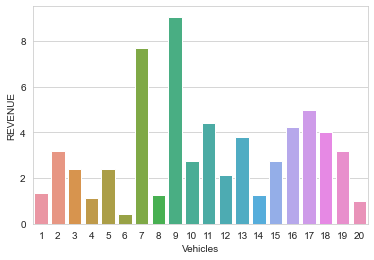

In [66]:
import seaborn as sns
sns.set_style("whitegrid")
sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

ax =sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE")
#for i in ax.containers:
    #ax.bar_label(i,)

# Total Revenue of all the driver 

In [67]:
sim.res[0].all_kpi # All driver revenue 

63.451499999999996

# Strategy 2: 

# params.kpi = 2 (Solo ride-hailing) 


In [68]:
params.kpi = 2

In [69]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

23-02-23 13:31:38-WARNING-Setting up 4h simulation at 2023-02-23 11:16:43 for 20 vehicles and 200 passengers in Delft, Netherlands
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
23-02-23 13:31:39-CRITICAL-this is request 7 with [7, 305] available rides.
23-02-23 13:31:39-CRITICAL-ride 7 available [1]
23-02-23 13:31:39-CRITICAL-ride 305 available [1, 0]
23-02-23 13:31:39-CRITICAL-this is reuqest 7 with [7, 305] still available rides.
23-02-23 13:31:39-CRITICAL-vehicle 4 has 2 choices
23-02-23 13:31:39-CRITICAL-vehicle 4 has chosen to serve request 7 with a ride 7 of degree 1, with travellers [7].
0.5
23-02-23 13:31:39-CRITICAL-this is request 8 with [8, 305] available rides.
23-02-23 13:31:39-CRITICAL-ride 8 available [1]
23-02-23 13:31:39-CRITICAL-ride 305 not available [5, 1]
23-02-23 13:31:39-CRITICAL-this is reuqest 8 with [8] still available rides.
0.5
0.5
0.5
23-02-23 13:31:39-CRITICAL-this is request 11 with [11, 292] available rides.
23-02-23 13:31:39-CRITICAL-ride 11 available [1]
23-02-23 13

In [70]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,14,0.0,False,0,0,7778.0,180.0,0,365.0,0,...,0,0,7685.0,3557.0,0,1614.0,965.0,1549.0,40.903,1.3272
2,11,0.0,False,0,0,10852.0,120.0,0,486.0,0,...,0,0,6334.0,2561.0,0,916.0,936.0,1921.0,34.848,9.0675
3,14,0.0,False,0,0,9535.0,180.0,0,251.0,0,...,0,0,7358.0,2789.0,0,1068.0,849.0,2652.0,30.632,2.7660
4,11,0.0,False,0,0,9325.0,150.0,0,206.0,0,...,0,0,8000.0,2632.0,0,956.0,686.0,3726.0,29.433,7.7112
5,9,0.0,False,0,0,10771.0,135.0,0,175.0,0,...,0,0,7988.0,1725.0,0,535.0,580.0,5148.0,17.278,0.9816
6,13,0.0,False,0,0,9185.0,165.0,0,329.0,0,...,0,0,7314.0,2577.0,0,1639.0,884.0,2214.0,30.808,2.4048
7,11,0.0,False,0,0,10567.0,135.0,0,400.0,0,...,0,0,7337.0,2152.0,0,678.0,865.0,3642.0,26.442,4.4004
8,7,0.0,False,0,0,10613.0,105.0,0,140.0,0,...,0,0,8236.0,1553.0,0,742.0,455.0,5486.0,15.555,3.2052
9,12,0.0,False,0,0,9863.0,135.0,0,252.0,0,...,0,0,7769.0,2404.0,0,816.0,747.0,3802.0,29.273,4.0032


In [71]:
sim.res[0].veh_exp['REVENUE'].to_list()

[1.3272000000000002,
 9.067499999999999,
 2.7660000000000005,
 7.7112,
 0.9815999999999999,
 2.4048000000000003,
 4.400399999999999,
 3.2052,
 4.0032,
 4.251600000000001,
 2.4,
 2.1564,
 4.975200000000001,
 0.42479999999999996,
 1.2611999999999999,
 3.8160000000000003,
 3.186,
 1.1352,
 2.7372,
 1.2408000000000001]

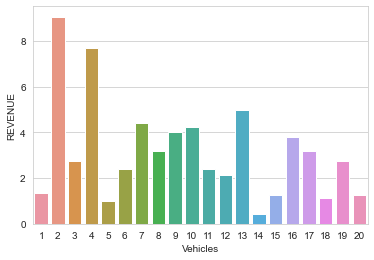

In [72]:
import seaborn as sns
sns.set_style("whitegrid")

sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

ax =sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE")
#for i in ax.containers:
    #ax.bar_label(i,)

# Total revenue of all the driver

In [73]:
sim.res[0].all_kpi # All driver revenue 

63.451499999999996

# Strategy 3: 
# params.kpi = 3 (Nearest pickup ride-pooling)


In [74]:
params.kpi = 3

In [75]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

23-02-23 13:31:52-WARNING-Setting up 4h simulation at 2023-02-23 11:16:43 for 20 vehicles and 200 passengers in Delft, Netherlands
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
23-02-23 13:31:53-CRITICAL-this is request 7 with [7, 305] available rides.
23-02-23 13:31:53-CRITICAL-ride 7 available [1]
23-02-23 13:31:53-CRITICAL-ride 305 available [1, 0]
23-02-23 13:31:53-CRITICAL-this is reuqest 7 with [7, 305] still available rides.
hell
23-02-23 13:31:53-CRITICAL-vehicle 18 has 2 choices
23-02-23 13:31:53-CRITICAL-vehicle 18 has chosen to serve request 7 with a ride 305 of degree 2, with travellers [7, 8].
0.5
23-02-23 13:31:53-CRITICAL-this is request 8 with [8, 305] available rides.
23-02-23 13:31:53-CRITICAL-ride 8 available [1]
23-02-23 13:31:53-CRITICAL-ride 305 not available [5, 1]
23-02-23 13:31:53-CRITICAL-this is reuqest 8 with [8] still available rides.
0.5
0.5
0.5
23-02-23 13:31:53-CRITICAL-this is request 11 with [11, 292] available rides.
23-02-23 13:31:53-CRITICAL-ride 11 available [1]

In [76]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,14,0.0,False,0,0,7778.0,180.0,0,365.0,0,...,0,0,7685.0,3557.0,0,1614.0,965.0,1549.0,40.903,1.3272
2,12,0.0,False,0,0,9863.0,135.0,0,252.0,0,...,0,0,7769.0,2404.0,0,816.0,747.0,3802.0,29.273,4.0032
3,10,0.0,False,0,0,8854.0,92.0,0,227.0,0,...,0,0,8824.0,2187.0,0,1115.0,619.0,4903.0,30.442,4.2516
4,11,0.0,False,0,0,10567.0,135.0,0,400.0,0,...,0,0,7337.0,2152.0,0,678.0,865.0,3642.0,26.442,4.4004
5,11,0.0,False,0,0,7003.0,120.0,0,642.0,0,...,0,0,11014.0,1611.0,0,879.0,1092.0,7432.0,24.163,1.2408
6,14,0.0,False,0,0,9535.0,180.0,0,251.0,0,...,0,0,7358.0,2789.0,0,1068.0,849.0,2652.0,30.632,2.7660
7,10,0.0,False,0,0,10913.0,135.0,0,246.0,0,...,0,0,7005.0,2148.0,0,852.0,681.0,3324.0,24.086,2.4000
8,11,0.0,False,0,0,10852.0,120.0,0,486.0,0,...,0,0,6334.0,2561.0,0,916.0,936.0,1921.0,34.848,9.0675
9,6,0.0,False,0,0,11164.0,90.0,0,120.0,0,...,0,0,8385.0,1121.0,0,539.0,390.0,6335.0,11.246,1.1352


In [77]:
sim.res[0].veh_exp['REVENUE'].to_list()

[1.3272000000000002,
 4.0032,
 4.251600000000001,
 4.400399999999999,
 1.2408000000000001,
 2.7660000000000005,
 2.4,
 9.067499999999999,
 1.1352,
 3.8160000000000003,
 0.9815999999999999,
 2.1564,
 3.186,
 2.4048000000000003,
 3.2052,
 4.975200000000001,
 2.7372,
 7.7112,
 1.2611999999999999,
 0.42479999999999996]

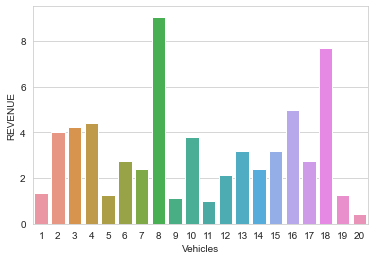

In [78]:
import seaborn as sns

sns.set_style("whitegrid")

sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

ax =sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE")

#ax.set(xlabel=None)
#for i in ax.containers:
    #ax.bar_label(i,)

# Total revenue of all the driver 

In [79]:
sim.res[0].all_kpi # All driver revenue 

63.451499999999996

# All in one Simulation  

In [7]:
responses = []
avg_kpi = []
idle_time = []

for i in range(1, 4):
    params.kpi = i
    sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate
    sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index
    sim.res[0].veh_exp['ds'] = f"{i}"
    
    responses.append(sim.res[0].veh_exp)
    
    vehicles = sim.res[0].veh_exp.loc[sim.res[0].veh_exp["nRIDES"] > 0]
    no_of_veh = len(vehicles)
    
    avg_kpi.append(sim.res[0].all_kpi/no_of_veh)
    idle_time.append(vehicles['IDLE'].sum()/no_of_veh)
    

23-02-23 13:37:20-INFO-Matching 200 trips to 329 rides in order to min u_veh
23-02-23 13:37:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         51,802 
reduced by matching to:               47,227
23-02-23 13:37:23-WARNING-Setting up 4h simulation at 2023-02-23 11:38:05 for 20 vehicles and 200 passengers in Delft, Netherlands
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
23-02-23 13:37:23-CRITICAL-this is request 8 with [8, 221, 244, 308, 309, 310, 324, 327] available rides.
23-02-23 13:37:23-CRITICAL-ride 8 available [1]
23-02-23 13:37:23-CRITICAL-ride 221 available [0, 1]
23-02-23 13:37:23-CRITICAL-ride 244 available [1, 0]
23-02-23 13:37:23-CRITICAL-ride 308 available [1, 0]
23-02-23 13:37:23-CRITICAL-ride 309 available [1, 0]
23-02-23 13:37:23-CRITICAL-ride 310 available [1, 0]
23-02-23 13:37:23-CRITICAL-ride 324 available [0, 1, 0]
23-02-23 13:37:23-CRITICAL-ride 327 available [1, 0, 0]
23-02-23 13:37:23-CRITICAL-this is reuqest 8 with [8, 221, 244, 308, 309, 310, 324,

# Performance Parameters for Driver

In [17]:
index = pd.Index(['Revenue', 'Profit', 'Cost', 'Idle Time'])
driver_data = pd.DataFrame({"Profit Maximization":[], "Pooled Ride": [], "Private Ride": []})
driver_data.loc['Revenue'] = avg_kpi
driver_data.loc['Idle Time'] = idle_time
driver_data.loc['Cost'] = driver_data.loc['Revenue'].apply(lambda x: x*params.shareability.operating_cost)

In [18]:
driver_data

,Profit Maximization,Pooled Ride,Private Ride
Revenue,3.236070,3.228990,3.228990
Idle Time,2853.750000,2828.050000,2818.300000
Cost,1.618035,1.614495,1.614495
